In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Input, models, regularizers
from tensorflow.keras.applications import MobileNetV2, MobileNetV3Small, EfficientNetB0, EfficientNetB1, MobileNetV3Large
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

## Visualize a few photos
It's always beneficial to thoroughly understand your data before beginning the training process. To get a first-hand impression of the dataset, please display a minimum of 20 images from the `train_val/` folder, along with their corresponding age and gender labels. This will help you gain initial insights into the dataset.

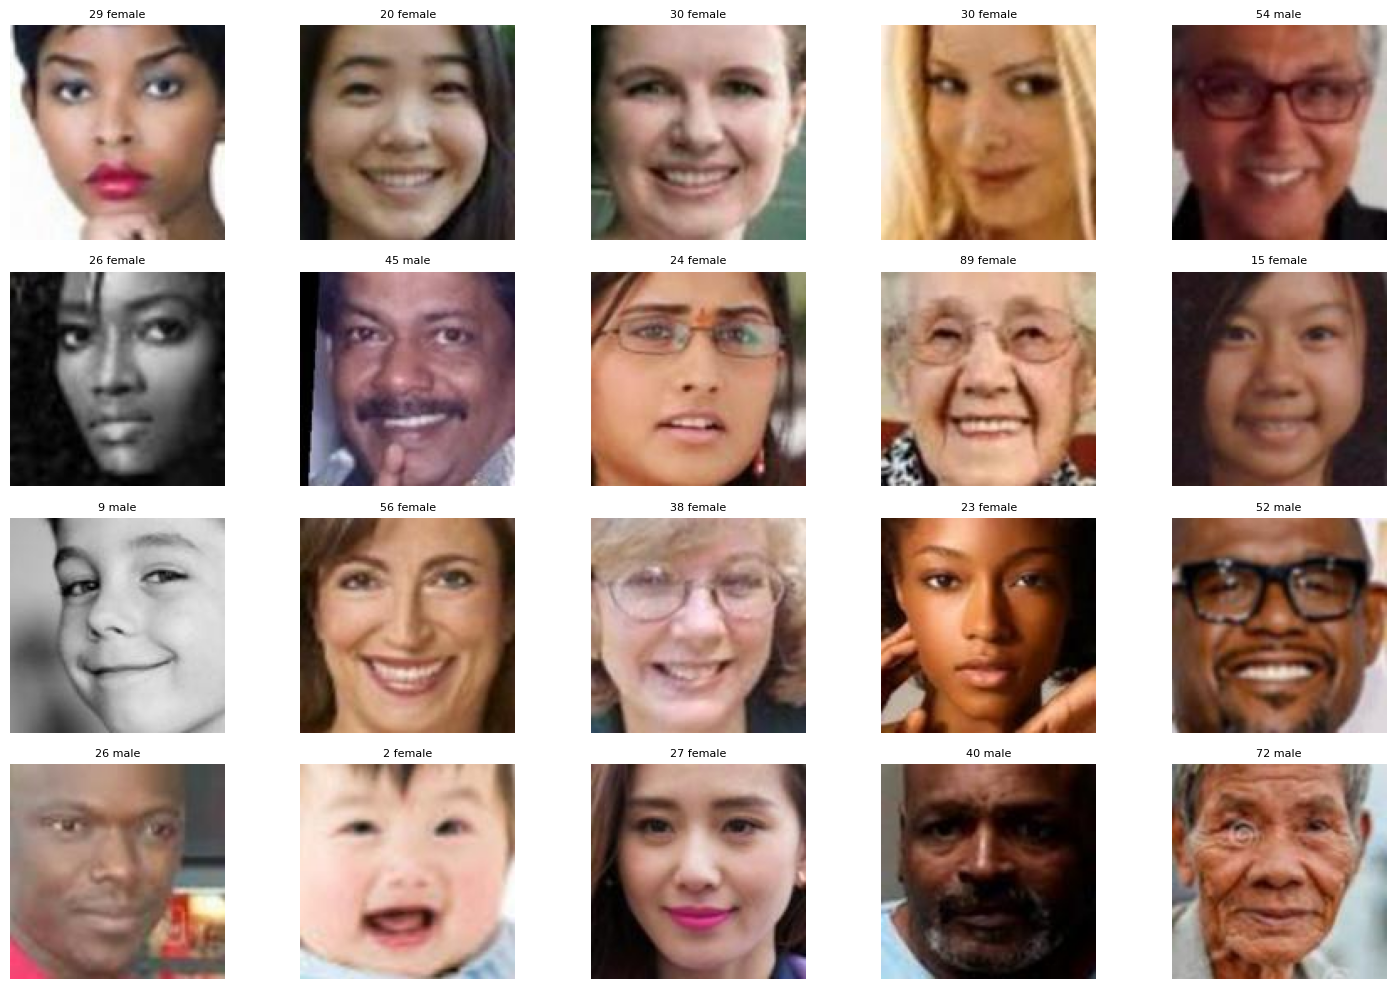

In [ ]:
# retrieve all file paths of images in train_val dataset
folder_train_val  = 'PATH_TO_IMAGES_FOLDER'

all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# get a random sample of 20 images
sample_images = random.sample(all_image_files, 20)

# plot images
plt.figure(figsize=(15, 10))
for i, img_file in enumerate(sample_images):
  img_file_path = folder_train_val + '/' + img_file
  age, gender, race, date_time = img_file.split('_')

  img = mpimg.imread(img_file_path)


  plt.subplot(4, 5, i+1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{age} {'male' if gender=='0' else 'female'}", fontsize=8)


plt.tight_layout()
plt.show()


## Step 1: Data Pre-Processing
In this step, you will perform necessary pre-processing tasks before feeding the data into a CNN. The pre-processing includes:

1. Splitting the data into training and validation sets.
2. Loading image data, gender labels and age values, and rescaling pixel values (originally integers between 0 and 255) to the range [0, 1].
3. Data augmentation

The first two pre-processing steps have already been completed for you. Your task in this step is limited to:

3. Data augmentation

Please note:

- Do not modify any part of the provided code except the section marked with ########.
- Do not rescale the age values to the range [0,1], as the original values are used during the testing stage. Rescaling them would significantly impact testing performance.



In [ ]:
import os
import random
import numpy as np

folder_train_val = 'PATH_TO_IMAGES_FOLDER'
all_image_files = [file for file in os.listdir(folder_train_val) if file.lower().endswith(('.jpg'))]

# Shuffle the dataset to ensure random distribution
random.seed(0)  # Ensure reproducibility
random.shuffle(all_image_files)

# Calculate the number of images for each set
n_train_val = len(all_image_files)
train_end = int(n_train_val * 0.8)

# Split the dataset
train_image_files = all_image_files[:train_end]
val_image_files = all_image_files[train_end:]
print(f"Number of images for training: {len(train_image_files)}")
print(f"Number of images for validation: {len(val_image_files)}")

def load_imgs_lables(dataset_path,filenames):
  print('load all image data, age and gender labels...')
  images = []
  age_labels = []
  gender_labels = []
  for current_file_name in filenames:
    img = cv2.imread(os.path.join(dataset_path, current_file_name))
    img = img / 255.0  # Normalize pixel values
    labels = current_file_name.split('_')
    age_label = int(labels[0])
    gender_label = int(labels[1])
    age_labels.append(age_label)
    gender_labels.append(gender_label)
    images.append(img)

  # Convert to NumPy arrays
  images = np.array(images)
  age_labels = np.array(age_labels)
  gender_labels = np.array(gender_labels)
  return images, age_labels, gender_labels

# load data from the training set
train_images, train_age, train_gender = load_imgs_lables(folder_train_val,train_image_files)

# load data from the validation set
val_images, val_age, val_gender = load_imgs_lables(folder_train_val,val_image_files)

#

data_augmentation = Sequential([
    layers.RandomFlip('horizontal'), # natural mirror variation
    layers.RandomRotation(0.03), # small tilt variation
    layers.RandomZoom(0.05), # small camera distance variation
    layers.RandomTranslation(0.05, 0.05), # small framing variation
    layers.RandomBrightness(0.2, value_range=(0.0, 1.0)),
    layers.RandomContrast(0.1), # slight contrast change

])

Number of images for training: 4000
Number of images for validation: 1000
load all image data, age and gender labels...
load all image data, age and gender labels...


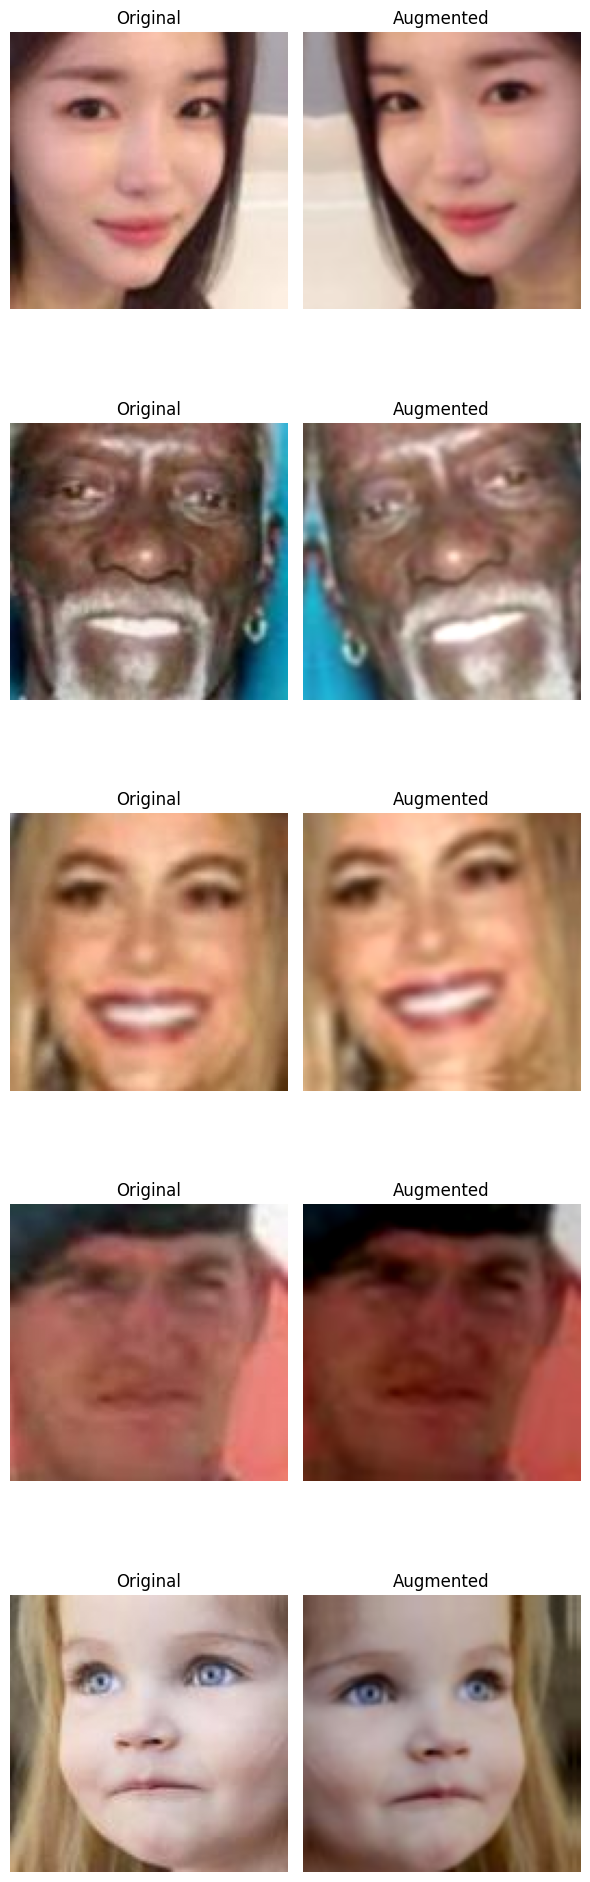

In [ ]:
# Visualise Augmented vs Original Images
num_examples = 5
example_idxs = random.sample(range(len(train_images)), num_examples)

plt.figure(figsize=(6, 4 * num_examples))

for i, idx in enumerate(example_idxs):
    original_img = train_images[idx]

    # Apply augmentation
    augmented_img = data_augmentation(tf.expand_dims(original_img, 0))
    augmented_img = tf.squeeze(augmented_img, axis=0)
    augmented_img = tf.clip_by_value(augmented_img, 0.0, 1.0)

    # Convert both to RGB for correct visualization
    original_img_rgb = original_img[..., ::-1]
    augmented_img_rgb = augmented_img[..., ::-1]

    # Plot original
    plt.subplot(num_examples, 2, 2*i + 1)
    plt.imshow(original_img_rgb)
    plt.title("Original")
    plt.axis("off")

    # Plot augmented
    plt.subplot(num_examples, 2, 2*i + 2)
    plt.imshow(augmented_img_rgb.numpy())
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

## STEP2A: Build your own CNN network
In this step, you will define your own CNN model for identifying gender and predicting age. Although there are two tasks, you only need to build one CNN model with two outputs. You may refer to online resources for solutions.

Here are the key requirements and restrictions for your network:
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2. Although it is technically correct to treat gender classification as a multi-class problem with 2 classes, i.e., 2 units in the last layer, the test code only supports a 1-unit last-layer configuration for the gender branch.
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	Incorporate techniques to prevent overfitting as appropriate.

At the end of your implementation, use `modelA.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ sequential[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 16, 16,    │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_4[

 Total params: 2,259,906 (8.62 MB)

 Trainable params: 2,258,434 (8.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

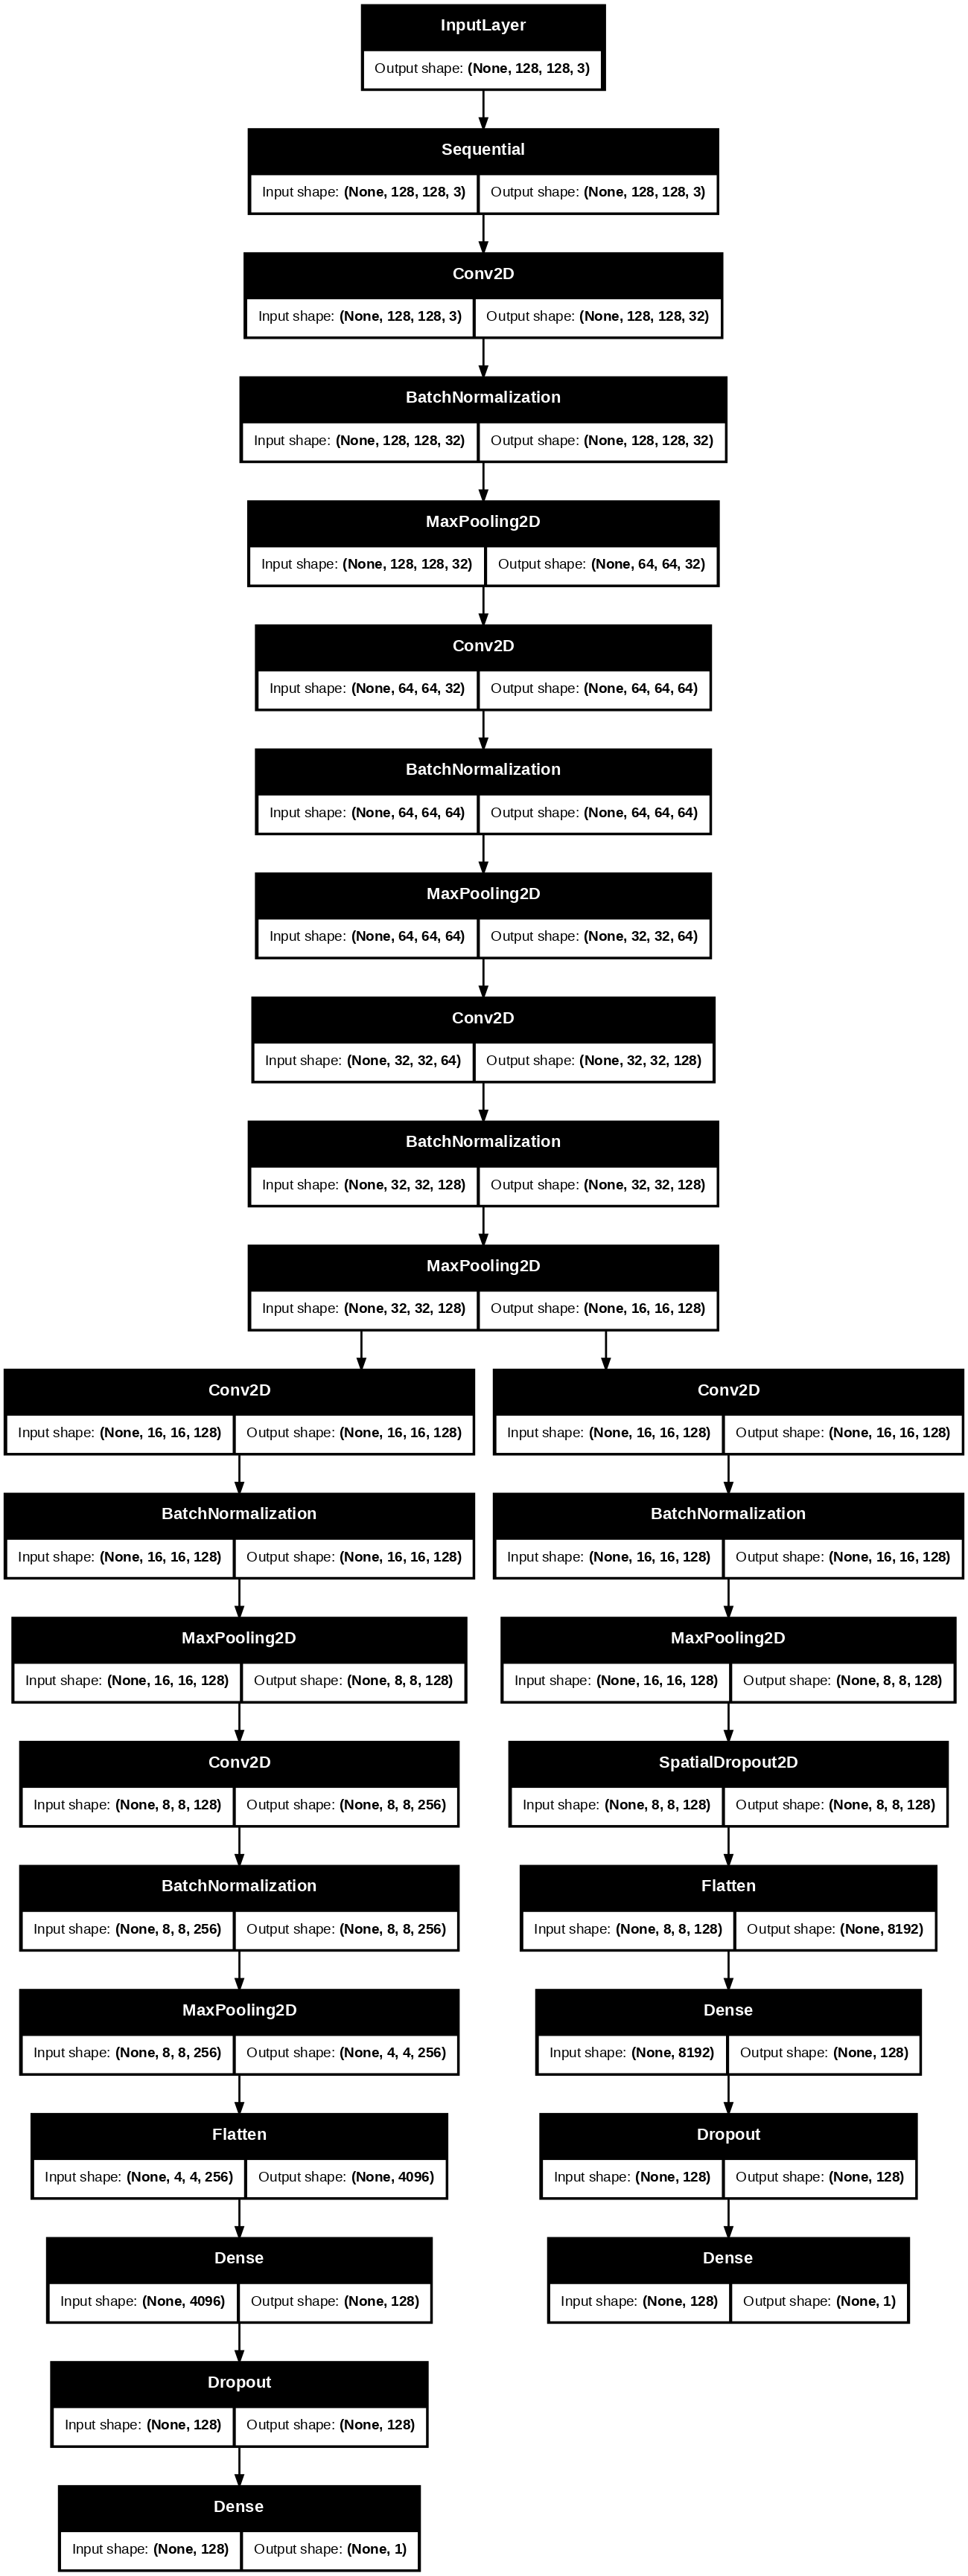

In [ ]:
# Input image must be 128x128x3
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)


# Data Augmentation
x = data_augmentation(inputs)


# Shared backbone
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)


# Gender classification head
g = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
g = layers.BatchNormalization()(g)
g = layers.MaxPooling2D((2,2))(g)
g = layers.SpatialDropout2D(0.1)(g)
g = layers.Flatten()(g)
g = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4))(g)
g = layers.Dropout(0.4)(g)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(g)


# Age regression head
a = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
a = layers.BatchNormalization()(a)
a = layers.MaxPooling2D((2,2))(a)
a = layers.Conv2D(256, (3,3), activation='relu', padding='same')(a)
a = layers.BatchNormalization()(a)
a = layers.MaxPooling2D((2,2))(a)
a = layers.Flatten()(a)
a = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(5e-5))(a)
a = layers.Dropout(0.3)(a)
age_output = layers.Dense(1, activation='linear', name='age_output')(a)


# Define model
modelA = models.Model(inputs=inputs, outputs=[gender_output, age_output])


modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True,dpi=100)

## STEP3A: Compile and train your model
Compile and train your model here.
Save your model by `modelA.save(your_model_folder+"age_gender_A.keras")` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()`** to save the entire model (including a model's architecture, weights, and training configuration) as a `.keras` zip archive. Don't save it with `save_weights()`.


In [ ]:
modelA.compile(
    optimizer=Adam(learning_rate=2e-4),
    loss={
        'gender_output': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),  # classification loss
        'age_output': 'mae'                      # regression loss
    },
    loss_weights = {
        'gender_output': 1.0,
        'age_output': 0.3,
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, mode='min') # stop training model when model stops improving -> helps prevent overfitting
reduce_lr_on_plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1, mode='min')

# Train the model
history = modelA.fit(
    x=train_images,
    y={'gender_output': train_gender, 'age_output': train_age},
    validation_data=(val_images, {'gender_output': val_gender, 'age_output': val_age}),
    epochs=80,
    batch_size=32,
    callbacks=[early_stop, reduce_lr_on_plateau],
    verbose=1
)


folder_models = '/content/drive/MyDrive/deep_learning_coursework/'
modelA.save(folder_models+'Model_A.keras')

Epoch 1/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - age_output_loss: 16.4463 - age_output_mae: 16.4463 - gender_output_accuracy: 0.6608 - gender_output_loss: 0.7933 - loss: 5.7649 - val_age_output_loss: 27.8289 - val_age_output_mae: 27.7359 - val_gender_output_accuracy: 0.4870 - val_gender_output_loss: 1.7893 - val_loss: 10.1679 - learning_rate: 2.0000e-04
Epoch 2/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - age_output_loss: 12.4681 - age_output_mae: 12.4681 - gender_output_accuracy: 0.7493 - gender_output_loss: 0.5402 - loss: 4.3183 - val_age_output_loss: 23.9017 - val_age_output_mae: 23.8054 - val_gender_output_accuracy: 0.4870 - val_gender_output_loss: 2.4695 - val_loss: 9.6771 - learning_rate: 2.0000e-04
Epoch 3/80
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - age_output_loss: 11.0903 - age_output_mae: 11.0903 - gender_output_accuracy: 0.7953 - gender_output_loss: 0.4744 - loss: 3.8392 - val_age_output_loss: 22.4626 - val_age_output_mae: 22.3674 - val_gender_output_accuracy: 0.

## STEP4A: Draw the learning curves
Draw four learning curve figures for model A as follows.
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

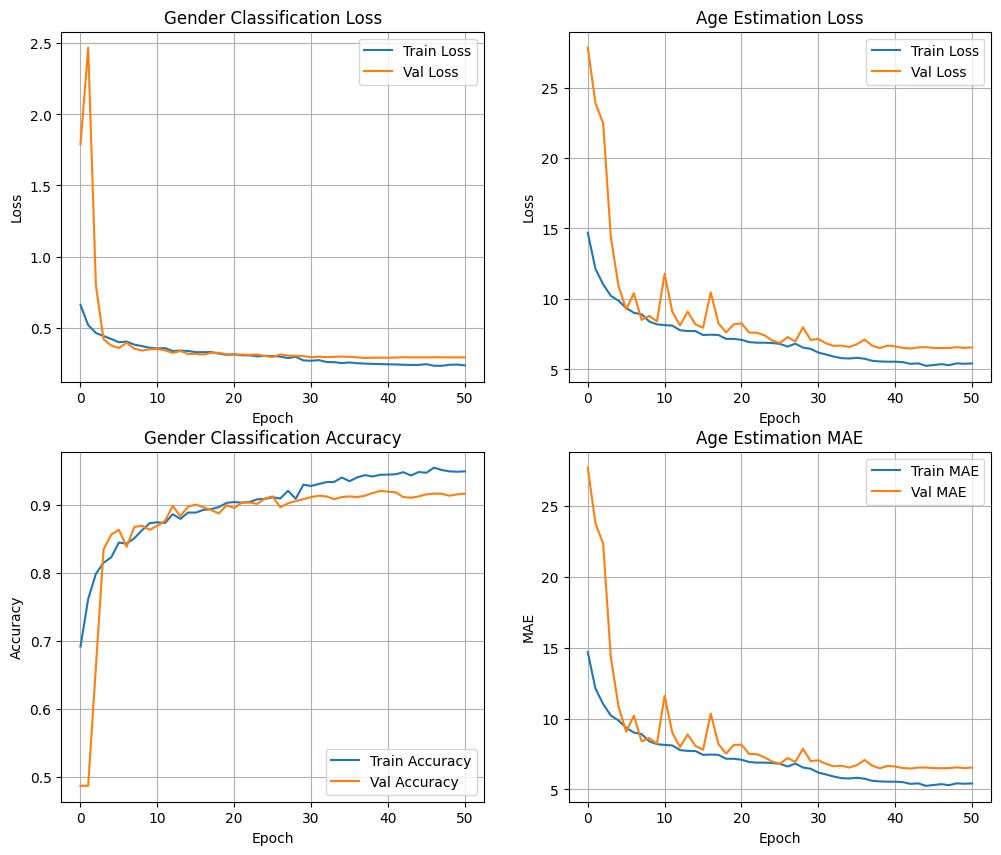

In [ ]:
# Retrieve history data
history_dict = history.history
epochs = range(len(history_dict['loss']))


def plot_result(train_key, val_key, title, ylabel, i):
    plt.subplot(2, 2, i)
    plt.plot(epochs, history_dict[train_key], label=f"Train {ylabel}")
    plt.plot(epochs, history_dict[val_key], label=f"Val {ylabel}")

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(12, 10))

# Gender classification loss
plot_result(
    'gender_output_loss',
    'val_gender_output_loss',
    "Gender Classification Loss",
    "Loss",
    1
)

# Age estimation loss
plot_result(
    'age_output_loss',
    'val_age_output_loss',
    "Age Estimation Loss",
    "Loss",
    2
)

# Gender classification accuracy
plot_result(
    'gender_output_accuracy',
    'val_gender_output_accuracy',
    "Gender Classification Accuracy",
    "Accuracy",
    3
)


# Age estimation MAE
plot_result(
    'age_output_mae',
    'val_age_output_mae',
    "Age Estimation MAE",
    "MAE",
    4
)

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model
Choose an existing CNN architecture pre-trained on ImageNet and fine-tune it on this dataset.

As with Model A, **do not resize the input image size**.
Ensure that the output layer for **the gender branch has only 1 unit**.

At the end of the cell, use `modelB.summary()` to display the model architecture and use `plot_model()` to visualize the architecture.


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "PretrainedAgeGenderCNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ lambda[0][0]      │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 128, 128,  │          0 │ sequential[0][0]  │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ lambda_1[0][0]    │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2560)      │      5,120 │ concatenate[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2560)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2560)      │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    327,808 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    655,616 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │         65 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        129 │ dense_3[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,079,461 (19.38 MB)

 Trainable params: 1,029,890 (3.93 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

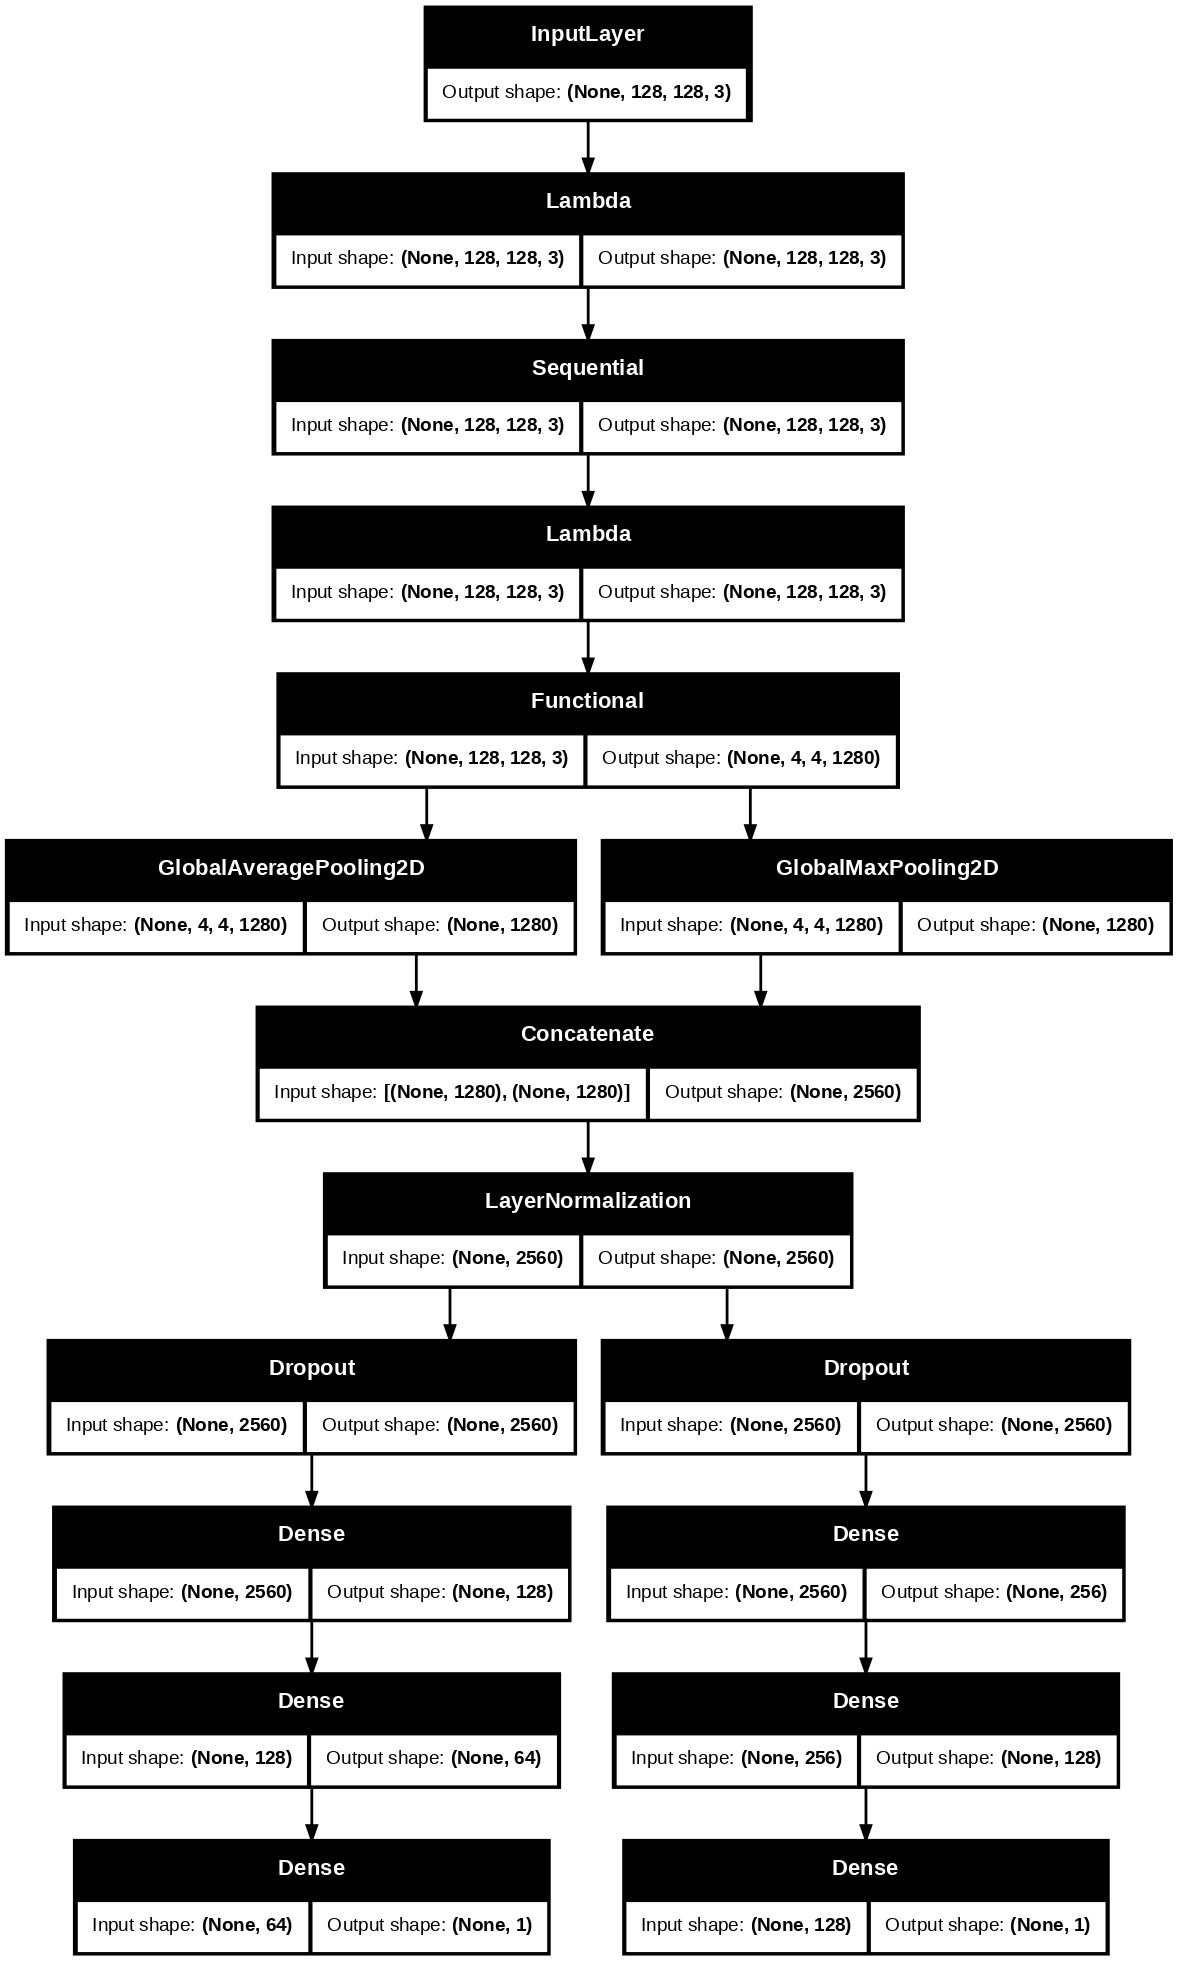

In [ ]:
input_shape = (128, 128, 3)
inputs = Input(shape=input_shape)

x = layers.Lambda(lambda t: t[..., ::-1], output_shape=input_shape)(inputs)
x = data_augmentation(x)
x = layers.Lambda(lambda t: t * 255.0, output_shape=input_shape)(x)
x = tf.keras.applications.efficientnet.preprocess_input(x)

base_model = EfficientNetB0(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

x = base_model(x)

gap = layers.GlobalAveragePooling2D()(x) # global soft features
gmp = layers.GlobalMaxPooling2D()(x) # sharp local features
x = layers.Concatenate()([gap, gmp])
x = layers.LayerNormalization()(x)

g = layers.Dropout(0.2)(x)
g = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(g)
g = layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(g)
gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(g)

a = layers.Dropout(0.2)(x)
a = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(a)
a = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-4))(a)
age_output = layers.Dense(1, activation='linear', name='age_output')(a)

modelB = models.Model(inputs=inputs, outputs=[gender_output, age_output], name="PretrainedAgeGenderCNN")

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True,dpi=100)

## STEP3B: Compile and train your model
Compile and train your model here.
Save your model to `age_gender_B.keras` after training.

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.**


In [ ]:
def unfreeze_last_n_layers(base_model, n_trainable):
    # Freeze everything first
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last n_trainable layers
    for layer in base_model.layers[-n_trainable:]:
        layer.trainable = True

    # keep all BatchNorm layers frozen
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False


# ------------ Phase 1 ----------------
base_model.trainable = False

modelB.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'gender_output': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        'age_output': 'mae'
    },
    loss_weights={
        'gender_output': 1.0,
        'age_output': 0.2,
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)

phase_1_callbacks = [
    ModelCheckpoint("phase1_best.weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
]
history_phase_1 = modelB.fit(
    train_images,
    {'gender_output': train_gender, 'age_output': train_age},
    validation_data=(val_images, {'gender_output': val_gender, 'age_output': val_age}),
    epochs=40,
    batch_size=32,
    callbacks=phase_1_callbacks,
    verbose=1
)

modelB.load_weights("phase1_best.weights.h5")

# -------------- Phase 2 -----------------
unfreeze_last_n_layers(base_model, n_trainable=120)

modelB.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss={
        'gender_output': tf.keras.losses.BinaryCrossentropy(label_smoothing=0.02),
        'age_output': 'mae'
    },
    loss_weights={
        'gender_output': 1.0,
        'age_output': 0.2,
    },
    metrics={
        'gender_output': ['accuracy'],
        'age_output': ['mae']
    }
)

phase_2_callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
]

history_phase_2 = modelB.fit(
    train_images,
    {'gender_output': train_gender, 'age_output': train_age},
    validation_data=(val_images, {'gender_output': val_gender, 'age_output': val_age}),
    epochs=80,
    batch_size=32,
    callbacks=phase_2_callbacks,
    verbose=1
)


your_model_folder = "/content/drive/MyDrive/deep_learning_coursework/"
modelB.save(your_model_folder+"Model_B.keras")

Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 93ms/step - age_output_loss: 19.7634 - age_output_mae: 19.7634 - gender_output_accuracy: 0.6814 - gender_output_loss: 0.6011 - loss: 4.6502 - val_age_output_loss: 11.1237 - val_age_output_mae: 11.0028 - val_gender_output_accuracy: 0.8070 - val_gender_output_loss: 0.4072 - val_loss: 2.7045 - learning_rate: 1.0000e-04
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - age_output_loss: 11.1641 - age_output_mae: 11.1641 - gender_output_accuracy: 0.7918 - gender_output_loss: 0.4434 - loss: 2.7725 - val_age_output_loss: 10.1337 - val_age_output_mae: 10.0852 - val_gender_output_accuracy: 0.8100 - val_gender_output_loss: 0.4040 - val_loss: 2.5156 - learning_rate: 1.0000e-04
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - age_output_loss: 10.4324 - age_output_mae: 10.4324 - gender_output_accuracy: 0.7909 - gender_output_loss: 0.4481 - loss: 2.6306 - val_age_output_loss: 9.9631 - val_age_output_mae: 9.9641 - val_gender_output_accuracy: 0.828

## STEP4B: Draw the learning curves
Draw four learning curve figures for model B as follows.
1. The loss of the gender classification over the training and validation set
2. The accuracy of the gender classification over the training and validation set
3. The loss of the age estimation over the training and validation set
4. The MAE of the age estimation over the training and validation set

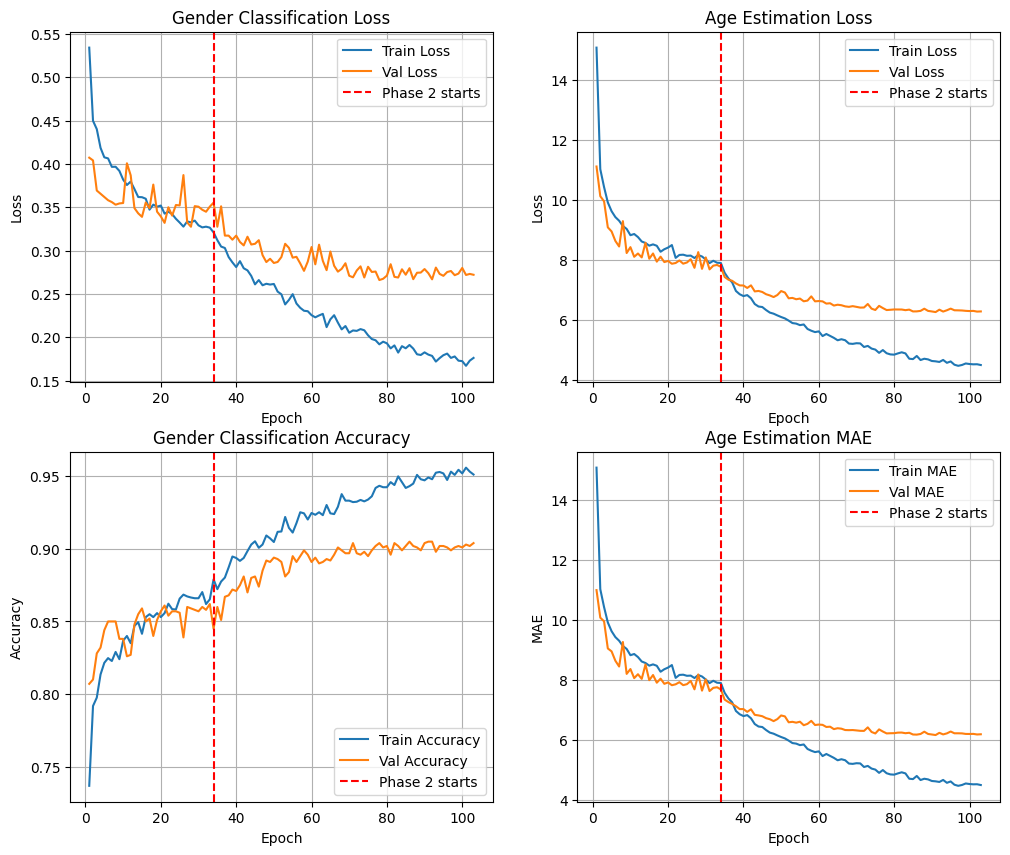

In [ ]:
# combine history data

history_dict = {}

for key in history_phase_1.history.keys():
  history_dict[key] = history_phase_1.history[key] + history_phase_2.history[key]

epochs = range(1, len(history_dict['loss']) + 1)
phase2_start_epoch = len(history_phase_1.history['loss']) + 1

def plot_with_phase_marker(train_key, val_key, title, ylabel, i):
    plt.subplot(2, 2, i)
    plt.plot(epochs, history_dict[train_key], label=f"Train {ylabel}")
    plt.plot(epochs, history_dict[val_key], label=f"Val {ylabel}")

    # Add vertical line marking start of Phase 2
    plt.axvline(x=phase2_start_epoch, color='red', linestyle='--', label="Phase 2 starts")

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(12, 10))

# Gender classification loss
plot_with_phase_marker(
    'gender_output_loss',
    'val_gender_output_loss',
    "Gender Classification Loss",
    "Loss",
    1
)

# Age estimation loss
plot_with_phase_marker(
    'age_output_loss',
    'val_age_output_loss',
    "Age Estimation Loss",
    "Loss",
    2
)

# Gender classification accuracy
plot_with_phase_marker(
    'gender_output_accuracy',
    'val_gender_output_accuracy',
    "Gender Classification Accuracy",
    "Accuracy",
    3
)


# Age estimation MAE
plot_with_phase_marker(
    'age_output_mae',
    'val_age_output_mae',
    "Age Estimation MAE",
    "MAE",
    4
)

plt.show()


In [ ]:

your_model_folder = "PATH_TO_MODELS_FOLDER"
modelA_test = load_model(your_model_folder+'Model_A.keras', safe_mode=False)
modelB_test = load_model(your_model_folder+'Model_B.keras', safe_mode=False)

# evaluate training performance

print("\n ModelA training performance")
modelA_test.evaluate(train_images, {'gender_output': train_gender, 'age_output': train_age})
print("\n ModelA validation performance")
modelA_test.evaluate(val_images, {'gender_output': val_gender, 'age_output': val_age})

print("\n ModelB training performance")
modelB_test.evaluate(train_images, {'gender_output': train_gender, 'age_output': train_age})
print("\n ModelB validation performance")
modelB_test.evaluate(val_images, {'gender_output': val_gender, 'age_output': val_age})



 ModelA training performance
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - age_output_loss: 4.2572 - age_output_mae: 4.2572 - gender_output_accuracy: 0.9696 - gender_output_loss: 0.2029 - loss: 1.5140

 ModelA validation performance
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - age_output_loss: 6.5175 - age_output_mae: 6.5170 - gender_output_accuracy: 0.9210 - gender_output_loss: 0.2863 - loss: 2.2754

 ModelB training performance
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - age_output_loss: 4.0402 - age_output_mae: 4.0402 - gender_output_accuracy: 0.9672 - gender_output_loss: 0.1477 - loss: 1.0428

 ModelB validation performance
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - age_output_loss: 6.0227 - age_output_mae: 6.0167 - gender_output_accuracy: 0.9102 - gender_output_loss: 0.2520 - loss: 1.5424


[1.5969732999801636,
 0.2740207612514496,
 6.2715864181518555,
 6.172432899475098,
 0.9049999713897705]

## STEP5: Evaluate the model on the test set
I will load your two models for testing. The test set will not be available before your submission.

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#